#### Tools For Modern Macroeconometrics

## Term paper - 1st stage

##### Summer semester 2022/23

*Authors:* Petr Čala, Tomáš Bajcár
___
### *Environment preparation, package handling, and file validation:*

In [366]:
##### ENVIRONMENT PREPARATION #####

# Clean the environment
rm(list = ls()) 

#Plot display options
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6, xts.warn_dplyr_breaks_lag=FALSE, scipen=999)

set.seed(420)

##### STATIC #####

# Required packages
packages <- c(
  "pdfetch", # Downloading data
  "forecast", # autoplot function, ARIMA
  "xts", # plot.xts function
  "urca", # Unit root test
  "seasonal", # Seasonal adjustments
  "stats", # Autocorr fun, spectrum, periodogram
  "mFilter", # HP filter
  "neverhpfilter", # Hamilton's regression filter
  "tsbox",
  "strucchange", # Structural breaks in data
  "quantmod", # Period-over-period changes ("periodReturn")
  "TSA", # periodogram
  "statcheck", # Structural breaks
  "tseries" # Tests
)
# Other useful packages - "dplyr", "quantmod", "moments", "StableEstim", "stabledist", "tseries")

##### PREPARATION #####

# Load the source script
if (!file.exists("cala_termpaper_source.R")){
  print('Please make sure to put the source file \"cala_termpaper_source\" in
        your working directory.')
  stop("Source file failed to load.")
} else{
  source("cala_termpaper_source.R")
  print("Source file loaded.")
}

# Load packages
loadPackages(packages)


[1] "Source file loaded."
[1] "All packages loaded successfully"


### *Obtaining the data*:

We fetch the data using the *fetch* function form the `pdfetch` package. We will use the widest range of time possible, and with this, fetch the data for GDP and Consumer Price Index.

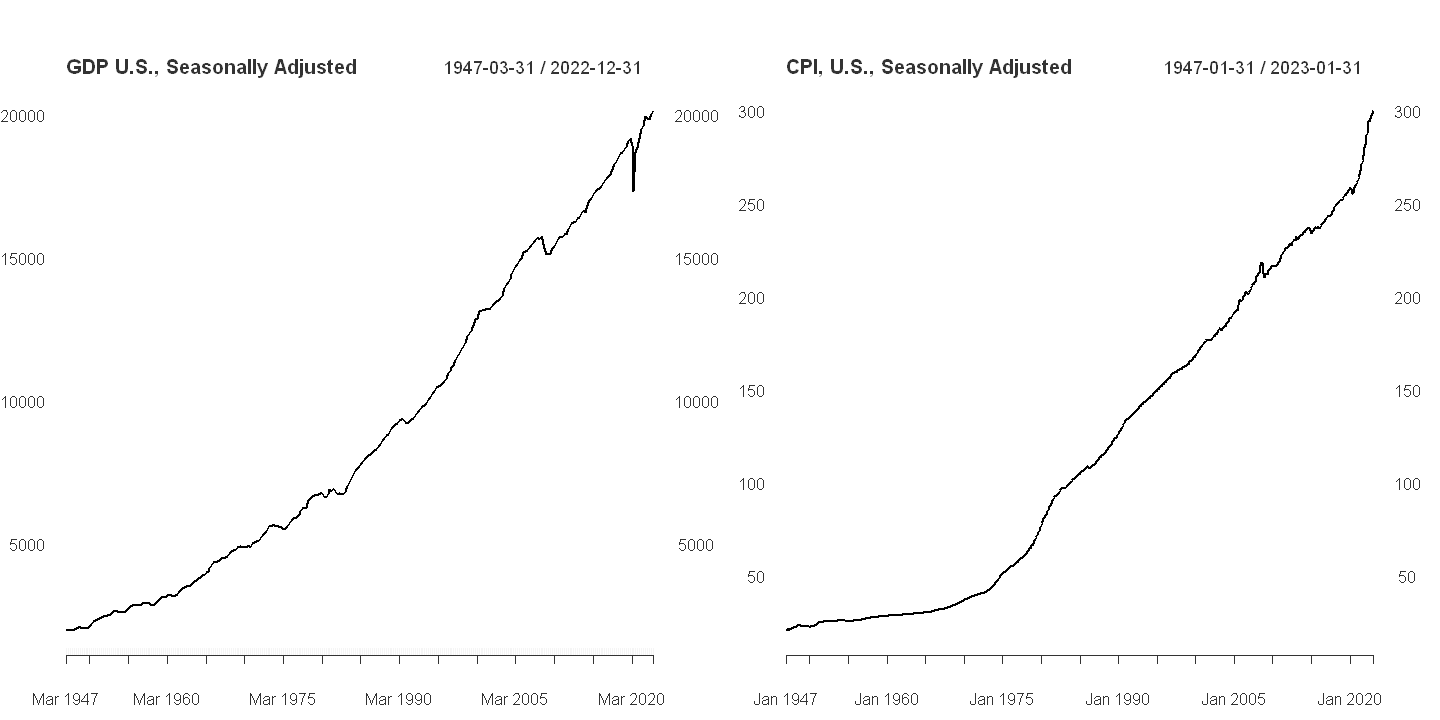

In [367]:
# Set the static variables
us_gdp_id <- "GDPC1" # https://fred.stlouisfed.org/series/GDPC1
us_cpi_id <- "CPIAUCSL" # https://fred.stlouisfed.org/series/CPIAUCSL

# Retrieve the U.S. GDP and consumer price index data using "pdfetch_FRED"
us_gdp_data <- pdfetch_FRED(us_gdp_id)
us_cpi_data <- pdfetch_FRED(us_cpi_id)

# Plot the original time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(us_gdp_data, main="GDP U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(us_cpi_data, main="CPI, U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)


### *Data transformation*:

Both series were available in the seasonally adjusted form, so we could skip step two. In case they were not, however, we appended a `handleSeasonality` function, which would extract the respective components out of the series. This function can be found in our source code, but we will not be using it.

For now, we will just transform the series to logs, as instructed.

[1] "Transforming the series to log..."


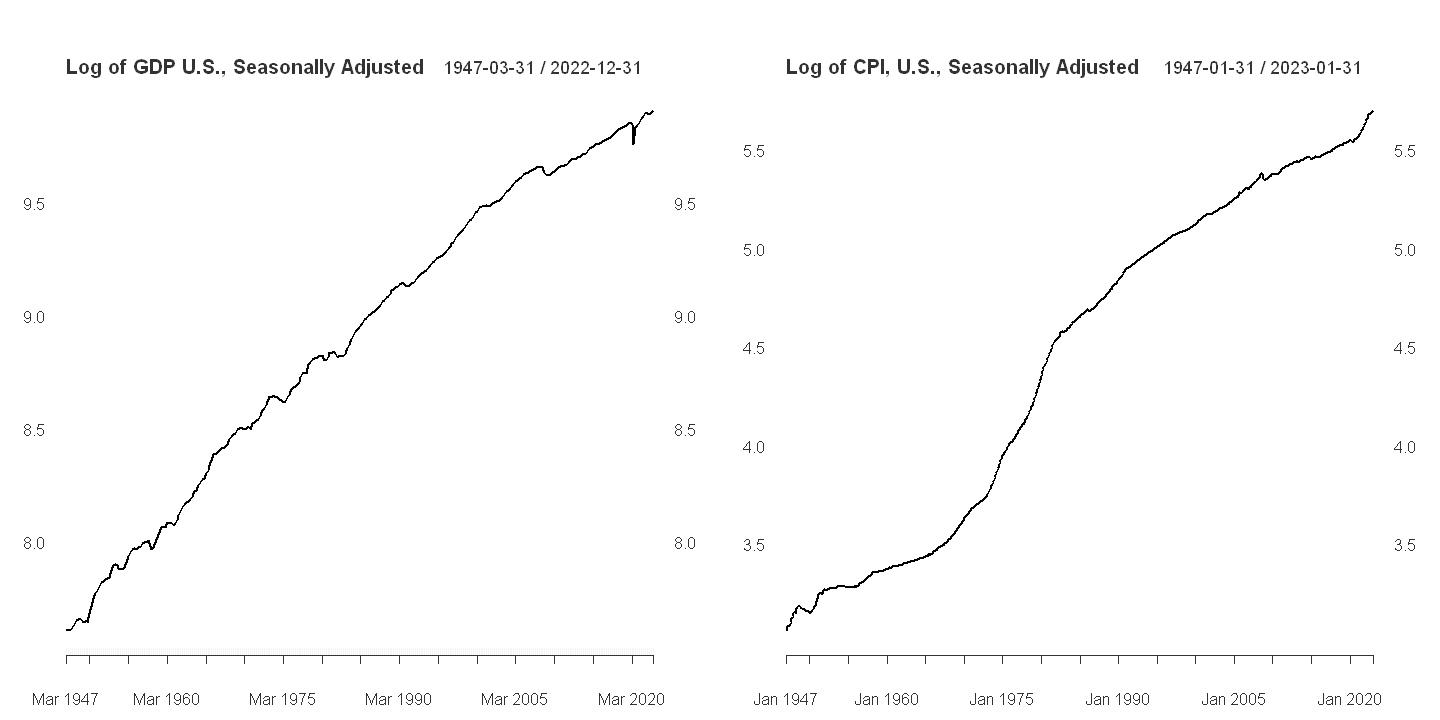

In [368]:
### 1.
print('Transforming the series to log...')
gdp_log <- log(us_gdp_data)
cpi_log <- log(us_cpi_data)

# Plot the new time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(gdp_log, main="Log of GDP U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_log, main="Log of CPI, U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
### 2.
# gdp_quarterly <- handleSeasonality(gdp_log, "GDP")
# cpi_log <- handleSeasonality(cpi_log, "CPI")

We can **check the data for stationarity, and order of integration**, using a custom function - `runStructuralChecks`.

In [369]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(gdp_log, "quarterly GDP", print_plots=F)
runStructuralChecks(cpi_log, "monthly CPI", print_plots=F)

[1] "Running structural checks for quarterly GDP"
[1] "Running the augmented Dickey-Fuller test for quarterly GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -1.197, Lag order = 1, p-value = 0.9057
alternative hypothesis: stationary

[1] "The transformed series is integrated of order 1"
[1] "Running structural checks for monthly CPI"
[1] "Running the augmented Dickey-Fuller test for monthly CPI..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -0.22199, Lag order = 1, p-value = 0.99
alternative hypothesis: stationary

[1] "The transformed series is integrated of order 1"


These checks suggest both series are integrated of order one, so **taking the percentage changes could make them stationary**.

After extracting the seasonal components from the CPI, we can take a look at the Y-O-Y, M-O-M, and P-O-P changes. For GDP, we can not do the M-O-M, because we do not have the data. With CPI, there arise several missing and infinite values when computing the percentage change, so we simply remove these, for simplicity. Otherwise, we make good use of a custom function, which allows us to directly compute the percentage changes, while defining the number of periods to look back during the computation.

In [370]:
### 3. 
print('Transforming data...')

## Period-over-period percentage changes
gdp_pop_change <- getPercentageChanges(gdp_log, "P-O-P GDP returns", look_back = 1) # Quarterly returns
cpi_pop_change <- getPercentageChanges(cpi_log, "P-O-P CPI returns", look_back = 1) # Monthly returns

# ## Calculate month-to-month changes
# Redundant - impossible for GDP due to lack of data, and already in that form for cpi

# ## Year-over-year percentage changes
gdp_yoy_change <- getPercentageChanges(gdp_log, "Y-O-Y GDP returns", look_back = 4)
cpi_yoy_change <- getPercentageChanges(cpi_log, "Y-O-Y CPI returns", look_back = 12)

print('Data transformation to percentage changes complete.')

[1] "Transforming data..."
[1] "Data transformation to percentage changes complete."


### *Structural validation*:

With these data, we can take a look at any potential remaining seasonal effects in the m-o-m series of CPI, and p-o-p series of GDP (because there are no monthly GDP data available). Then we check for structural breaks, stationarity, and other characteristics.

[1] "Running structural checks for quarterly GDP"
[1] "Running the augmented Dickey-Fuller test for quarterly GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -10.268, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"
[1] "Running structural checks for monthly CPI"
[1] "Running the augmented Dickey-Fuller test for monthly CPI..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -12.761, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


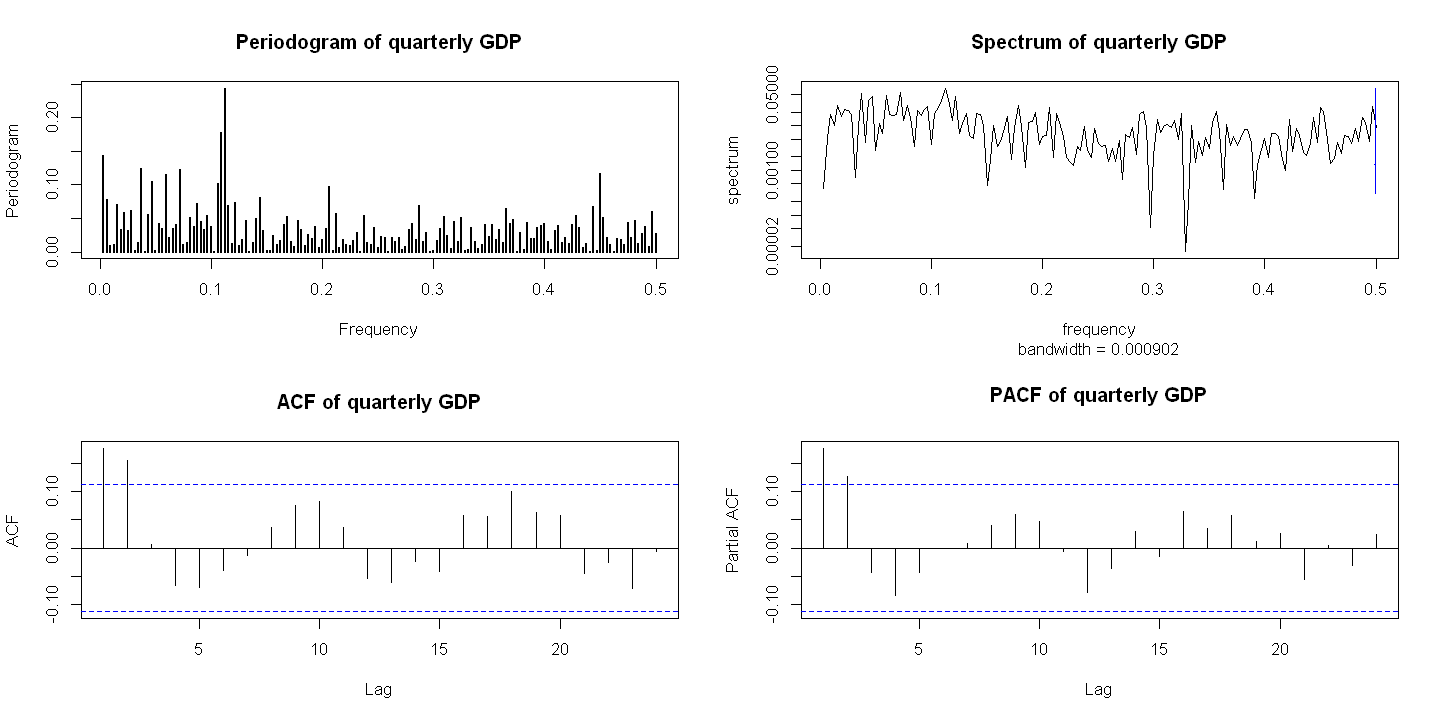

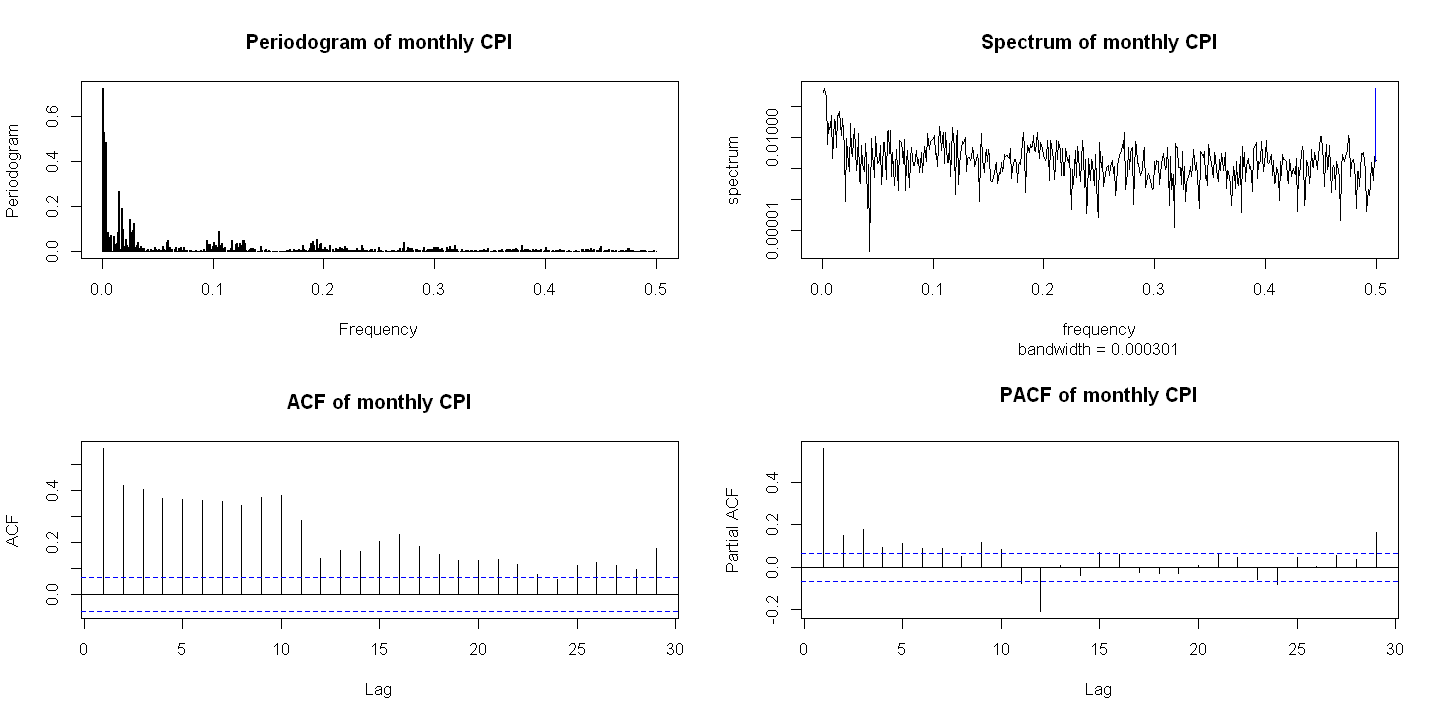

In [371]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(gdp_pop_change, "quarterly GDP")
runStructuralChecks(cpi_pop_change, "monthly CPI")

Both Dickey-Fuller tests suggest stationarity, however, by a quick glance, it is not clear whether all sesasonality has been removed from the CPI series. More than anything, there seems to be a strong persistence in the ACF of the CPI series, which is supported by the periodogram. It might suggest strong presence of low frequencies, or in other words, high persistence in the series, but there is a point to be made that this could indicate unit root. However, the Dickey-Fuller tests suggest strongly against this hypothesis, so we decide to trust them here. As for the spectrum, the take away is similar, with a hint of an increase in the density among lower frequencies. We will see what implications this may pose during the modelling section.

The GDP structural tests then look very stable, again, hinting slightly at a larger number of lower frequencies, as well as a lower order ARIMA model, possibly with a magnitude around 2. Let us check these suggestions empirically, now.

### *Linear Model Estimation*:

In this section, we will try to estimate several linear models, to see which fit the two series the best. Both of the series should be stationary, so linear models should work just fine in our case. We will model on the monthly data, which allow for the largest granularity. We will run the specification check models on data of other granularity at the end.

The ACF and PACF plots for either series suggest a simple model should suffice, say *ARMA(2,0)* in the case of GDP, and *ARMA(1,0)* in the case of CPI. We will first see what model the `auto.arima` function suggests, to get an idea, and then go on to



In [300]:
auto.arima(gdp_pop_change)
auto.arima(cpi_pop_change)

Series: gdp_pop_change 
ARIMA(3,1,2) 

Coefficients:
         ar1     ar2      ar3      ma1     ma2
      0.8868  0.0188  -0.1659  -1.7336  0.7394
s.e.  0.2232  0.0836   0.0573   0.2224  0.2194

sigma^2 = 0.01628:  log likelihood = 194.2
AIC=-376.41   AICc=-376.12   BIC=-354.14

Series: cpi_pop_change 
ARIMA(5,1,2) 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1     ma2
      0.9406  -0.4324  -0.0619  -0.1366  -0.1293  -1.5335  0.8283
s.e.  0.0837   0.0559   0.0496   0.0470   0.0381   0.0758  0.0794

sigma^2 = 0.004837:  log likelihood = 1138.75
AIC=-2261.5   AICc=-2261.34   BIC=-2222.98

`auto.arima` suggest *ARIMA(3,1,2)* for the GPD, and *ARIMA(5,1,2)* for CPI. We suppose that the integration of order 1 suggested for both series may arise from the variability in frequencies of the data, but otherwise the data appears stationary, so we do not think it necessary to include the integration order.

To get an idea of which orders might be good to model, we resort to an iterative function `getBoxLjung`, which will create 36 basic ARIMA models, and return the values of their Ljung-Box test, ran on their residuals, understandably. We will then search for a **tradeoff between the number of orders and the large p-value from the test**, as the simpler models are usually the best.

In [222]:
# Get the data frame of p-values from the B-L test
print('Monthly GDP Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(gdp_pop_change)

print('Monthly CPI Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(cpi_pop_change)

[1] "Monthly GDP Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,1 lag,2 lags,3 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.7299102,0.3309420,0.4695971
1,2,0.9859957,0.9894737,0.9991655
1,3,0.9790561,0.9912723,0.9921942
1,4,0.9867226,0.9997043,0.9999856
1,5,0.9959584,0.9999865,0.9999996
2,1,0.9804367,0.9750226,0.9969414
2,2,0.3919062,0.2389430,0.4110859
2,3,0.9442315,0.2323952,0.3995785
2,4,0.9725833,0.9837803,0.9940136


[1] "Monthly CPI Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,1 lag,2 lags,3 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.00155942,0.00003490583,0.00002216146
1,2,0.99014064,0.91128267582,0.97980483754
1,3,0.96478232,0.98679614085,0.99418873018
1,4,0.97410126,0.97429105386,0.96922641062
1,5,0.86537074,0.97289278547,0.99521541299
2,1,0.73939319,0.28474698860,0.45501796626
2,2,0.95529920,0.99304353280,0.99049680201
2,3,0.92665758,0.99498146109,0.89779920918
2,4,0.96448351,0.95910403587,0.93207147777


For GDP, the strongest candidate seems to be the *ARIMA(2,2)* model, where the residuals perform the best in the Ljung-Box test among models with low order of integration, the model range in which we would ideally like to search. However, when we ran this model, we found that no coefficients were statistically significant, so maybe autotocorrelation is not the only thing that matters. After a bit of fiddeling around, we decided to opt for the suggested *ARIMA(3,1,2)* model, as it laid on the cross-road of good Ljung-Box test performance, and coefficient significance.

When it comes to CPI, there was one big concern. No matter the model, we could not get rid of autocorrelation in higher lags of the series, notably around lag 12, which can be seen in both correlation functions below. This would suggest yearly trends in the data, but when we re-checked the seasonality using our `handleSeasonality` function, we got the same results, which only validated that our function is well written, and that **we indeed have seasonally adjusted data from the source**. We decided to not look too deep into this, and proceeded with the modelling as per usual, which led us to the model *ARIMA(1,0,2)*, the one that showed the best result in the two aforementioned criteria.

Results of the modelling can be seen below.


Call:
arima(x = gdp_pop_change, order = c(3, 1, 2))

Coefficients:
         ar1     ar2      ar3      ma1     ma2
      0.8868  0.0188  -0.1659  -1.7336  0.7394
s.e.  0.2232  0.0836   0.0573   0.2224  0.2194

sigma^2 estimated as 0.01601:  log likelihood = 194.2,  aic = -378.41


	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.020928, df = 1, p-value = 0.885



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.025734, df = 2, p-value = 0.9872



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.42714, df = 3, p-value = 0.9346


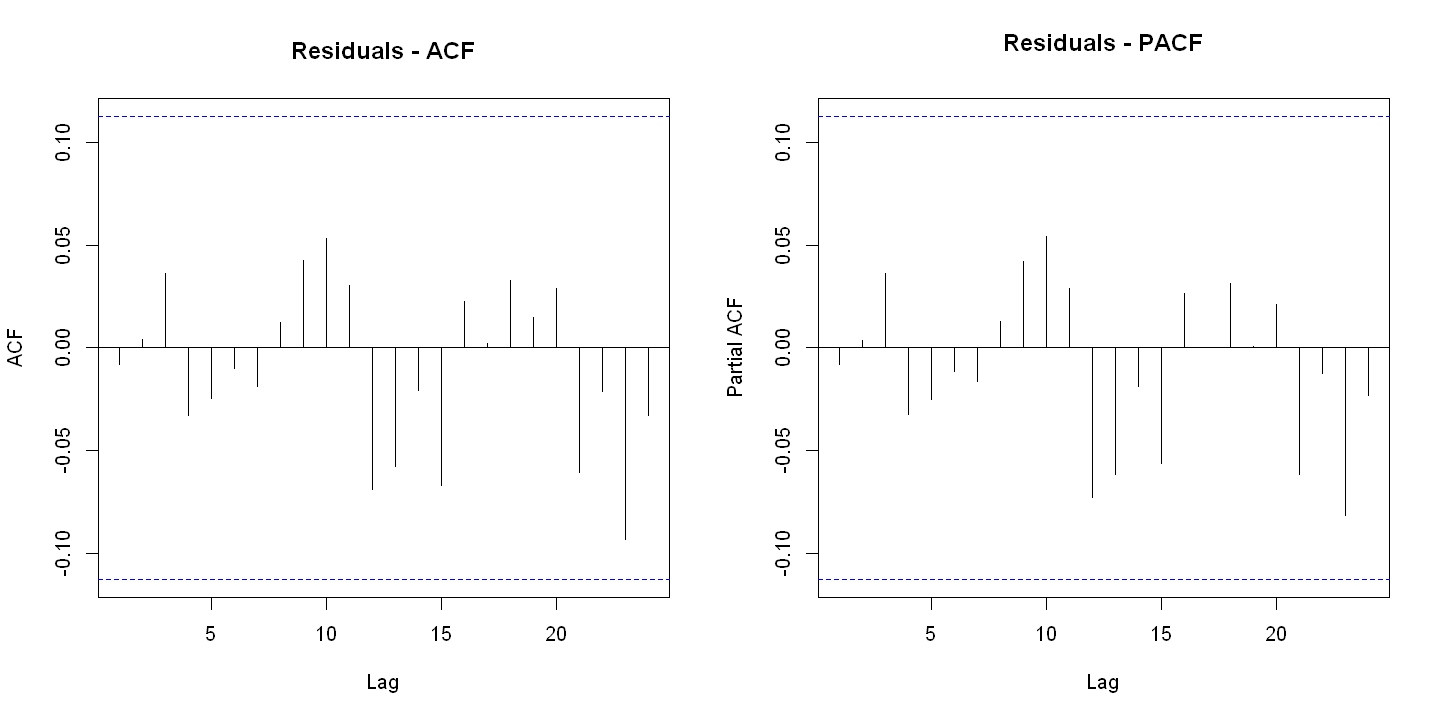

In [223]:
### 4.

## GDP ARMA modelling
GDP_ARMA <- arima(gdp_pop_change, order = c(3, 1, 2))
GDP_ARMA

par(mfrow = c(1, 2))
acf(GDP_ARMA$residuals, main = 'Residuals - ACF')
pacf(GDP_ARMA$residuals, main = 'Residuals - PACF')

Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 1)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 2)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 3)


Call:
arima(x = cpi_pop_change, order = c(1, 0, 2))

Coefficients:
         ar1      ma1      ma2  intercept
      0.9578  -0.5627  -0.1796     0.0707
s.e.  0.0140   0.0364   0.0346     0.0137

sigma^2 estimated as 0.004782:  log likelihood = 1141.92,  aic = -2275.83


	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 1.6367, df = 4, p-value = 0.8022



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 2.5688, df = 8, p-value = 0.9584



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 64.031, df = 12, p-value = 0.000000004117


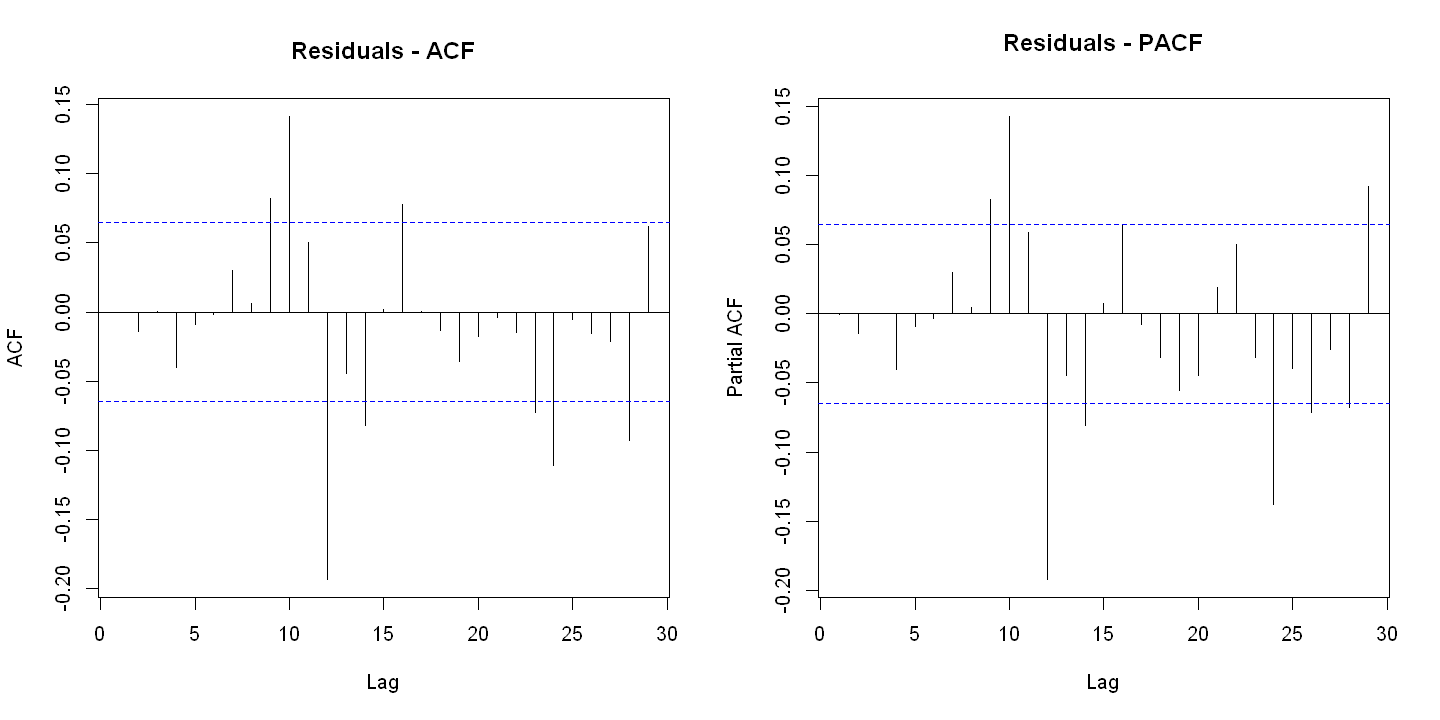

In [224]:
## CPI ARMA modelling
CPI_ARMA <- arima(cpi_pop_change, order = c(1, 0, 2))
CPI_ARMA

par(mfrow = c(1, 2))
acf(CPI_ARMA$residuals, main = 'Residuals - ACF')
pacf(CPI_ARMA$residuals, main = 'Residuals - PACF')

Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 4)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 8)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 12)


Now let's **run some forecasts**. This can be done using the `forecast` package.

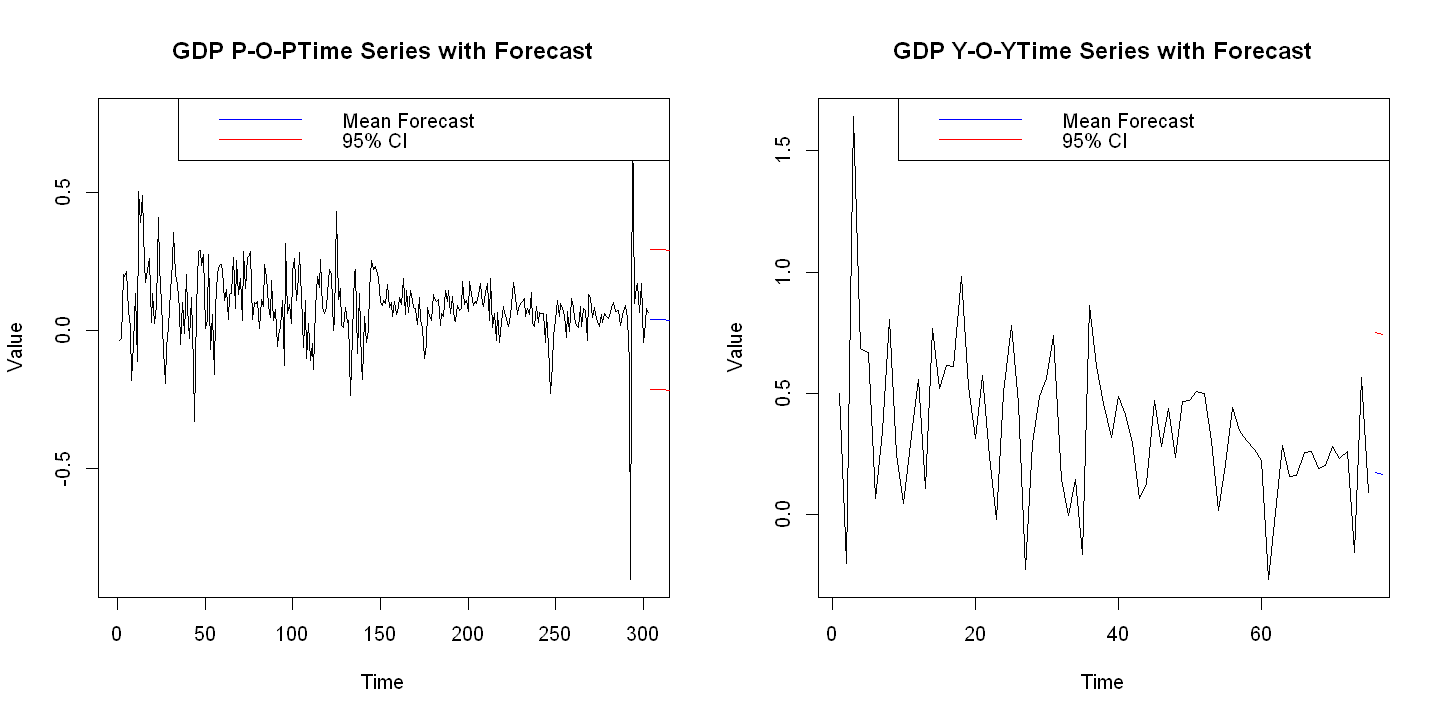

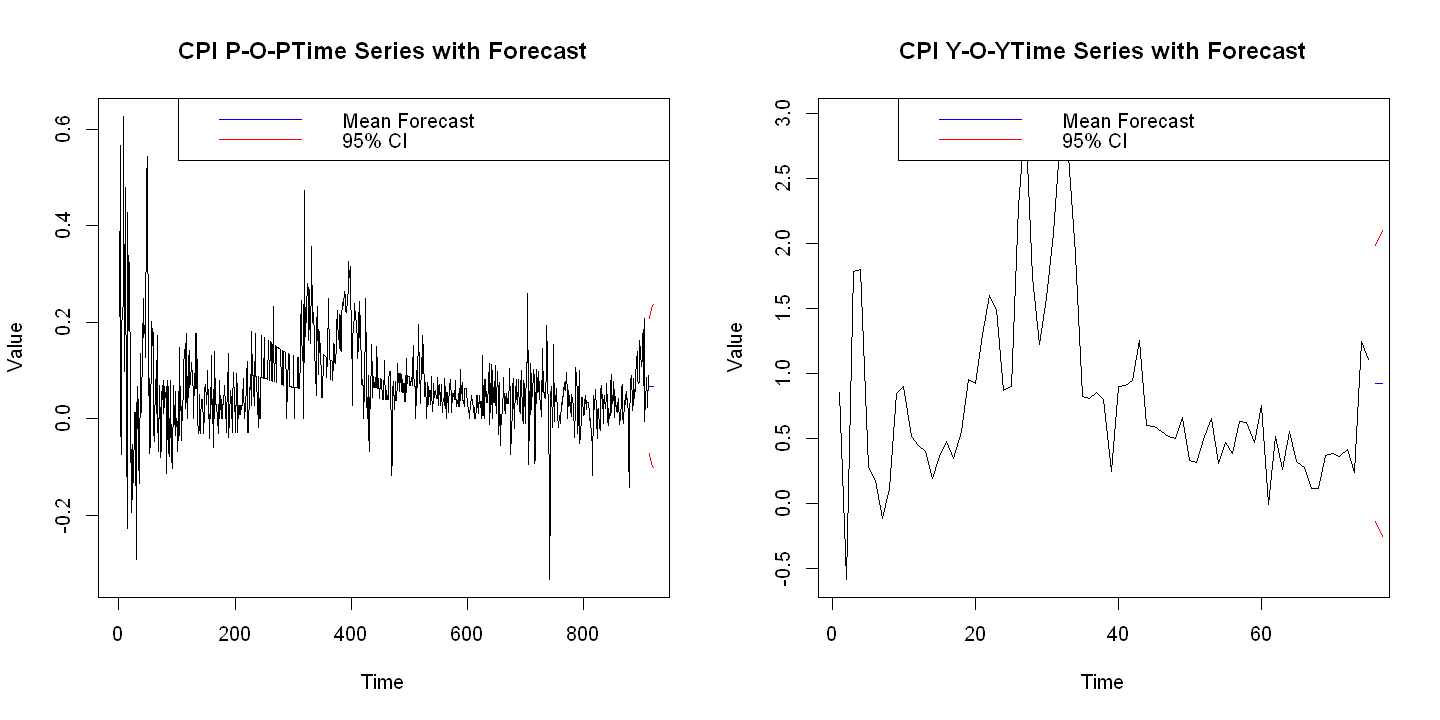

In [317]:
## Forecast 2 years ahead

# Forecast GDP
par(mfrow = c(1,2))
gdp_pop_forecast <- forecastData(gdp_pop_change, periods=24, date_frequency="month", series_name="GDP P-O-P")
gdp_yoy_forecast <- forecastData(gdp_yoy_change, periods=2, date_frequency="year", series_name="GDP Y-O-Y")

# Forecast CPI
par(mfrow = c(1,2))
cpi_pop_forecast <- forecastData(cpi_pop_change, periods=8, date_frequency="quarter", series_name="CPI P-O-P")
cpi_yoy_forecast <- forecastData(cpi_yoy_change, periods=2, date_frequency="year", series_name="CPI Y-O-Y")


In [318]:
# Print out the mean forecasted value
print(paste0("Mean value of P-O-P GDP: ", mean(gdp_pop_forecast)))
print(paste0("Mean value of Y-O-Y GDP: ", mean(gdp_yoy_forecast)))
print(paste0("Mean value of P-O-P CPI: ", mean(cpi_pop_forecast)))
print(paste0("Mean value of Y-O-Y CPI: ", mean(cpi_yoy_forecast)))


[1] "Mean value of P-O-P GDP: 0.0380333031887211"
[1] "Mean value of Y-O-Y GDP: 0.170034473090285"
[1] "Mean value of P-O-P CPI: 0.0679670564934817"
[1] "Mean value of Y-O-Y CPI: 0.927380810922388"


Now, we are able to run 2 forecasts for each series only - first, it's monthly for CPI, and quarterly for GDP, and then we have yearly for each of these two. This should be most sufficient, and in the case of GDP, we do not have the data to do more.

As for the forecasts themselves **we choose to run only the most simple form of a forecast, for that seems to be the instructions**. Otherwise, a rolling or expanding forecast could make the most sense, to account for the new, forecasted data. We may consider doing that in the future.

Looking at the results starting from the end, we chose to append a single mean for each of the predicted forecast, just to get an idea of the level that we are operating at, because all series (due to various aggregation) have slightly different values at the last observed value, so they are not directly comparable (meaning of course GDP x. GDP, and CPI x. CPI).

In general, it holds that the **yearly forecasts have a much wider confidence interval range**, due to fewer observations, and larger relative (and possibly also absolute) standard deviation. Otherwise, as far as we can tell, the direction of the forecast seems to hold across time aggregation, more or less, so the biggest difference should indeed be the confidence interval of the forecast.

### *Estimating the Output Gap*:

##### Hodrick-Prescott Filter:

We will start with obtaining the Hodrick-Prescott filter, and observing its various specifications.

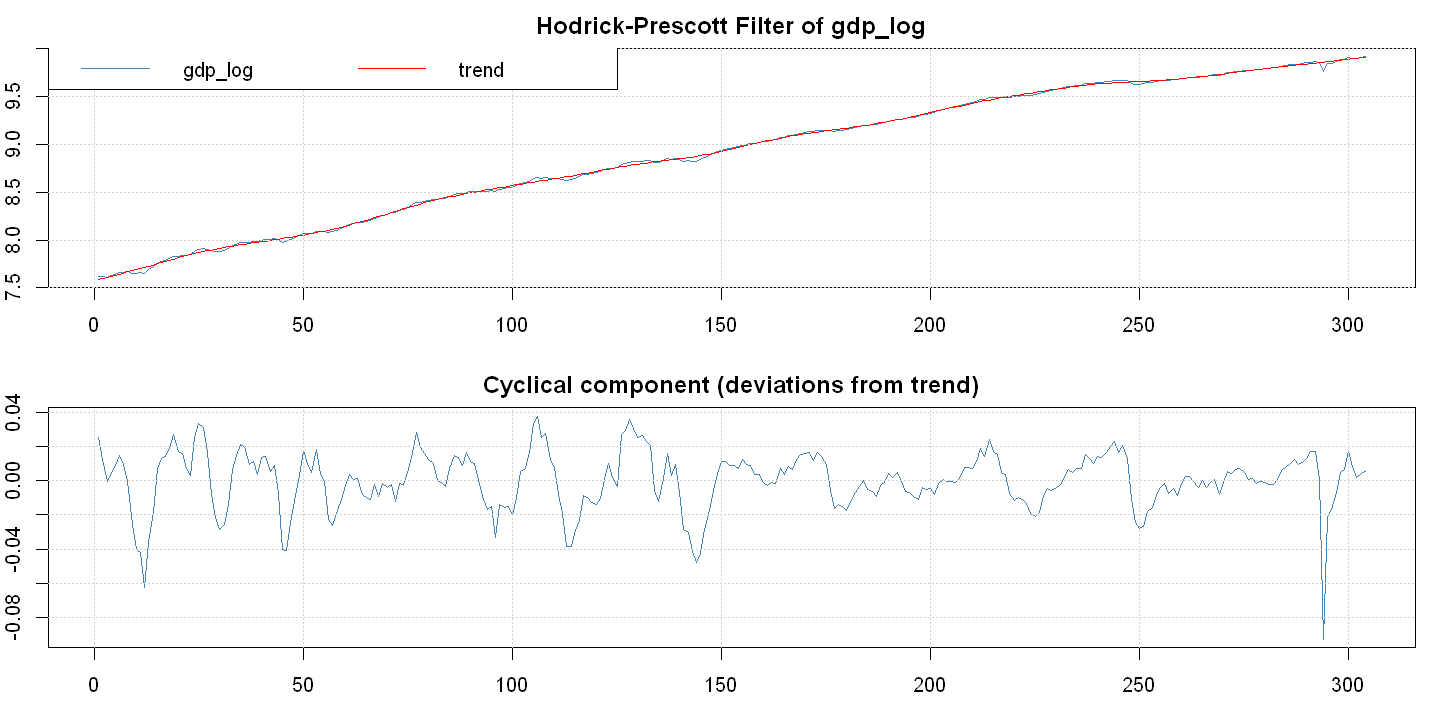

In [373]:
### 5.

# Hodrick-Prescott filter

hp <- hpfilter(gdp_log, freq=1600, type="lambda") # Source data have seasonality removed
hp_trend <- as.xts(hp$trend)
plot(hp)

To run the structural checks, we will make use of the function we defined before - `runStructuralChecks`.

[1] "Transforming data..."
[1] "Data transformation to percentage changes complete."
[1] "Running structural checks for Q-O-Q GDP"
[1] "Running the augmented Dickey-Fuller test for Q-O-Q GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -15.779, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"
[1] "Running structural checks for Y-O-Y GDP"
[1] "Running the augmented Dickey-Fuller test for Y-O-Y GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -16.227, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


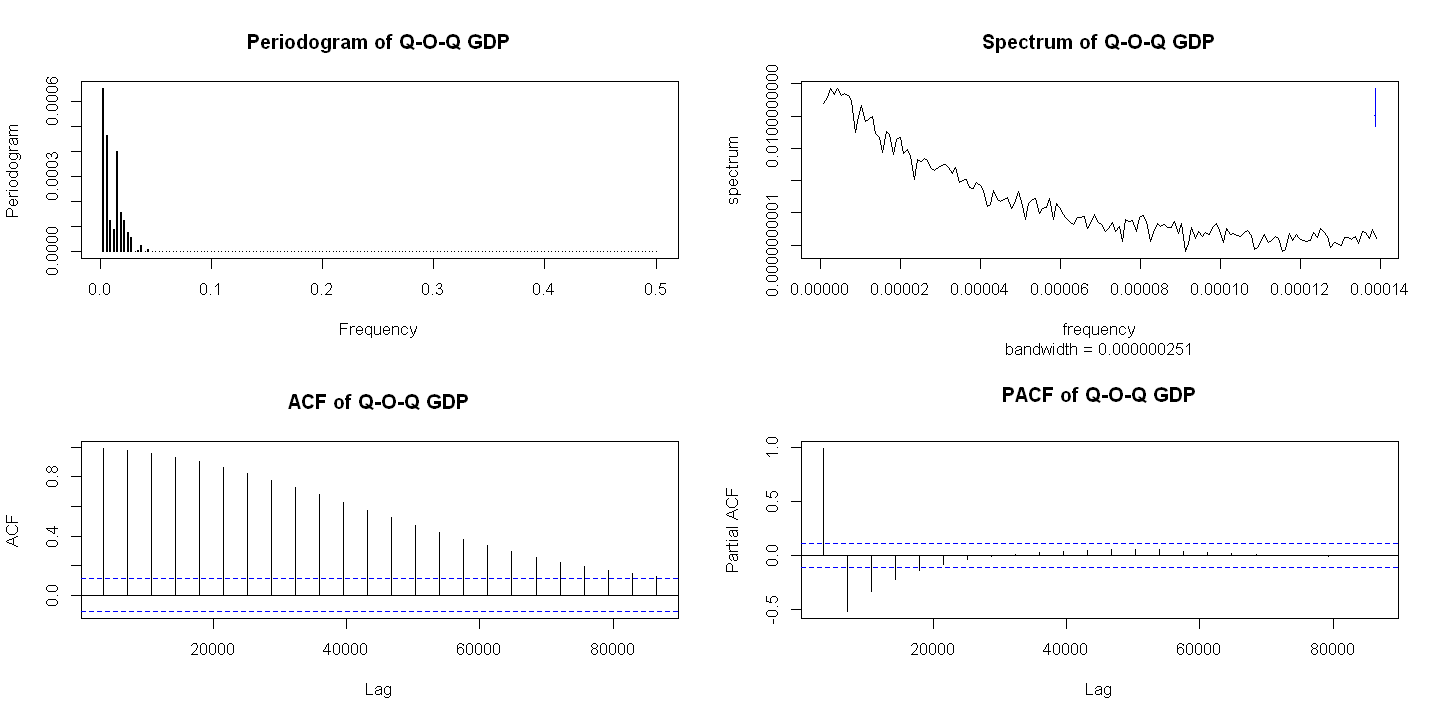

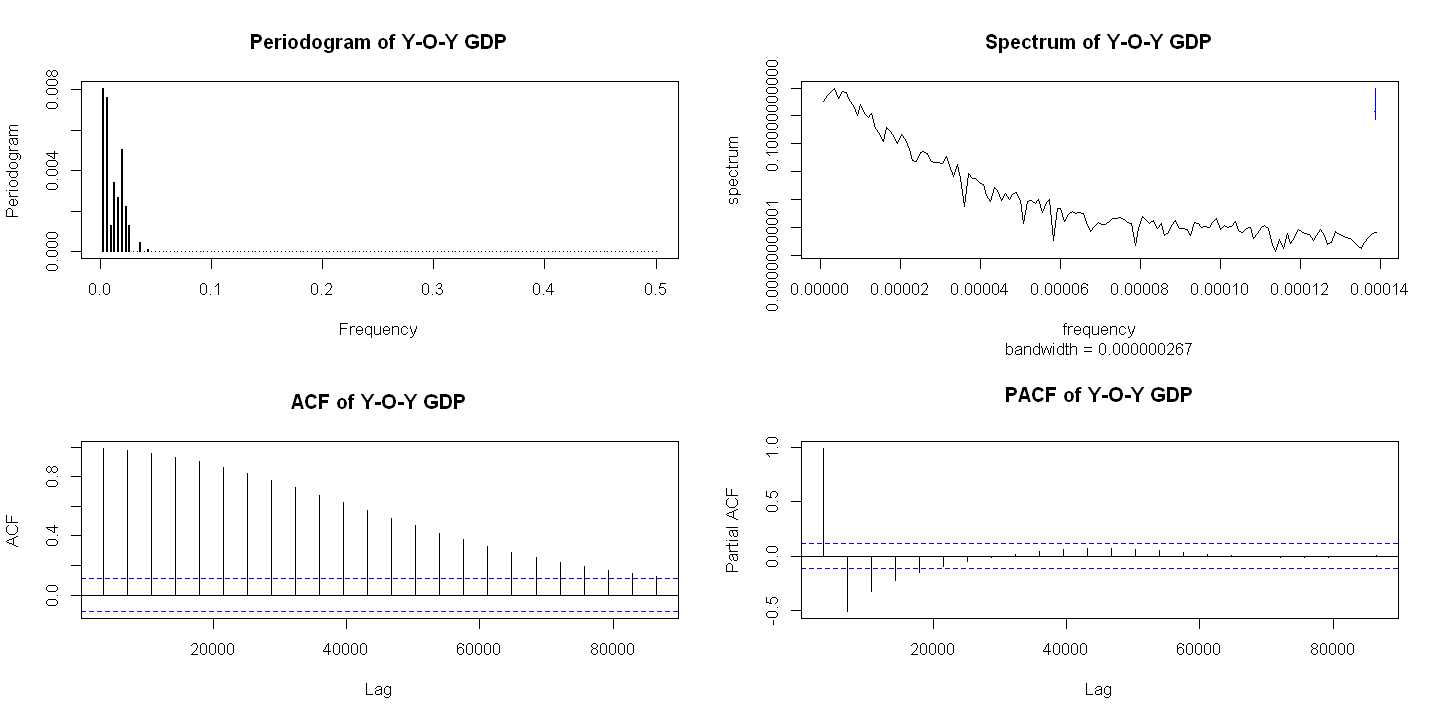

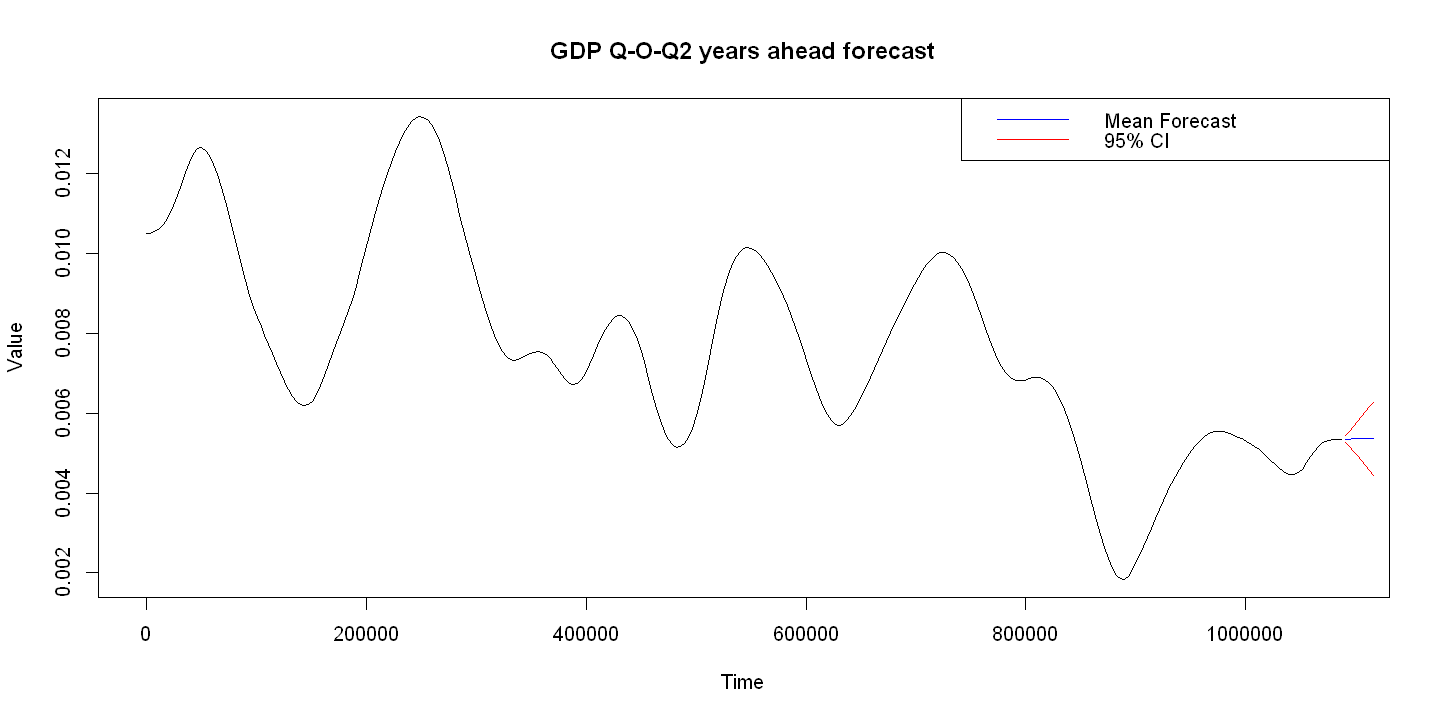

In [374]:
# HP filter specifications
print('Transforming data...')

## Differences of q-o-q and y-o-y
hp_qoq_change <- na.omit(diff(hp_trend, lag=1))
hp_yoy_change <- na.omit(diff(hp_trend, lag=4))

print('Data transformation to percentage changes complete.')

# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(hp_qoq_change, "Q-O-Q GDP")
runStructuralChecks(hp_yoy_change, "Y-O-Y GDP")

# Forecast using the GDP trend

par(mfrow=c(1,1))
hp_forecast <- forecastData(hp_qoq_change, periods=8, date_frequency="quarter", series_name="GDP Q-O-Q")

For the Hodrick-Prescott filter, we set the smoothing parameter to $\lambda = 1600$, as that is the best practice, as far as we remember. **The two spectrums do not vary notably**, retaining mostly low frequencies, and losing higher ones in both cases. **Both series should be stationary**, according to the Ljung-Box test, although, again, there seems to be strong and long persistence among lags, as shown in the ACF graph.

The forecast function shows us nothing interesting at first glance, as the mean forecast remains almost unchanging. Furthermore, given the large relative deviations of the quarter-over-quarter differences, which we use for forecasting, it may be naive to assume such small deviation for the forecast, but that is just our personal opinion.

##### Hamilton's regression filter

Next we move onto the *Hamilton's regression filter*. Building the filter is straightforward, and afterwards we use the same methodology for estimation as in the case of the H-P filter.

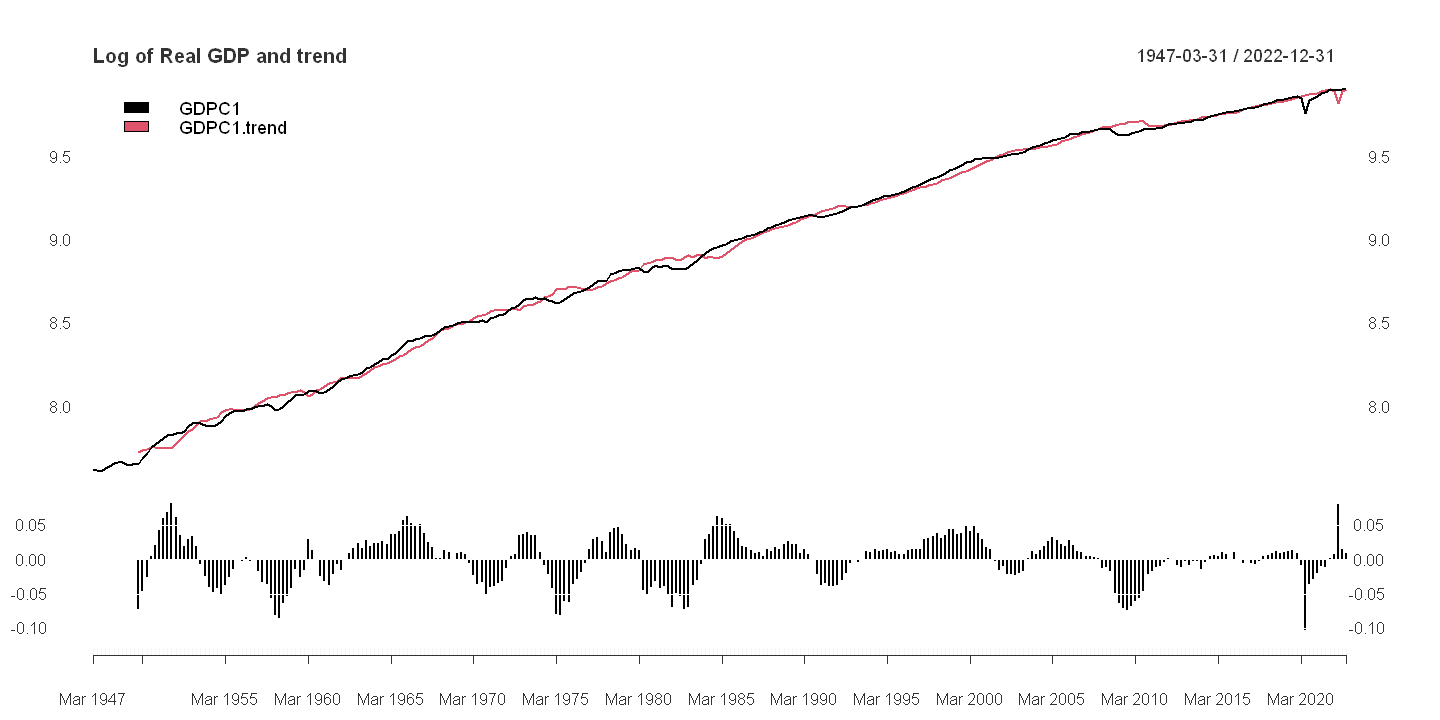

In [387]:
# Hamilton filter

gdp_HAM <- yth_filter(gdp_log, h= 8, p = 4)
ham_trend <- na.omit(gdp_HAM[,2])
par(mfrow=c(1,1))
plot(gdp_HAM[,1:2], grid.col = "white", legend.loc = "topleft", main = "Log of Real GDP and trend", panels = 'lines(gdp_HAM[,3], type="h", on=NA)')

[1] "Transforming data..."
[1] "Data transformation to percentage changes complete."
[1] "Running structural checks for Q-O-Q GDP"
[1] "Running the augmented Dickey-Fuller test for Q-O-Q GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -11.048, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"
[1] "Running structural checks for Y-O-Y GDP"
[1] "Running the augmented Dickey-Fuller test for Y-O-Y GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -6.1372, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


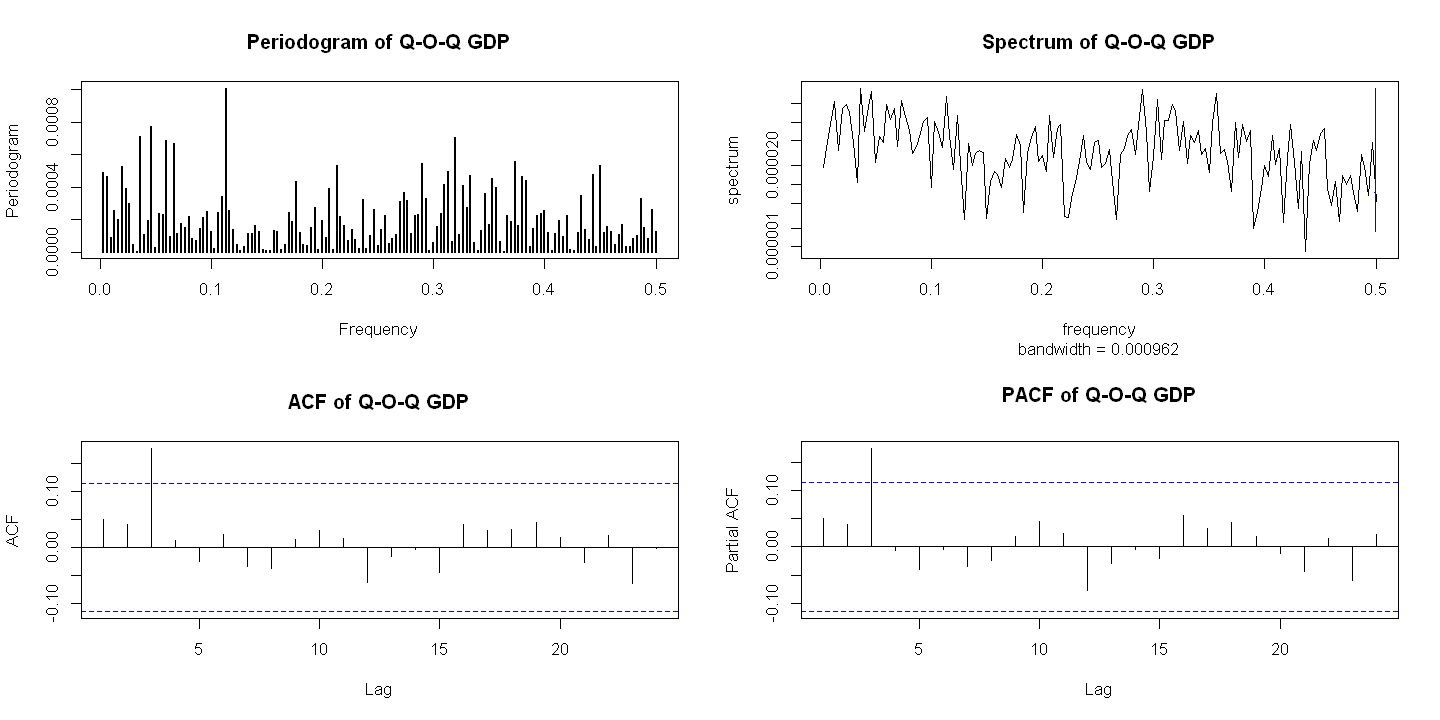

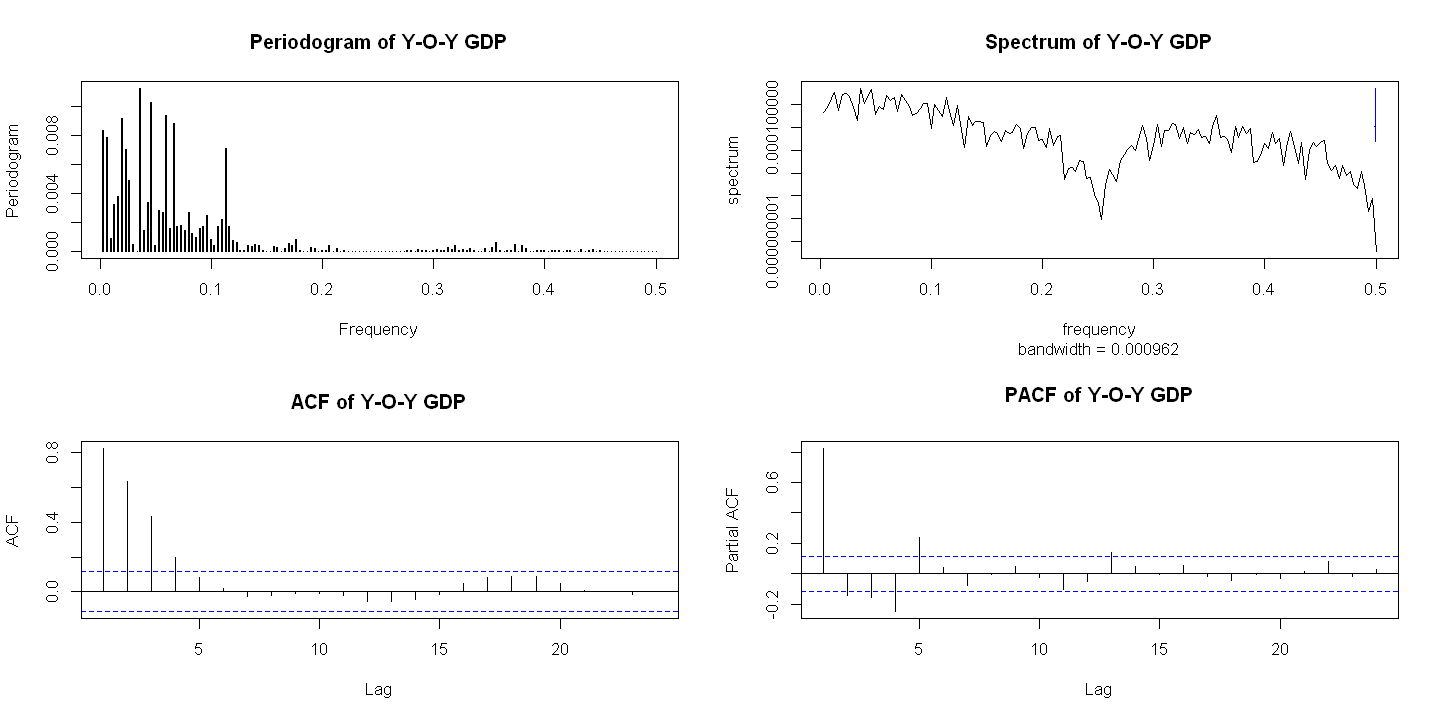

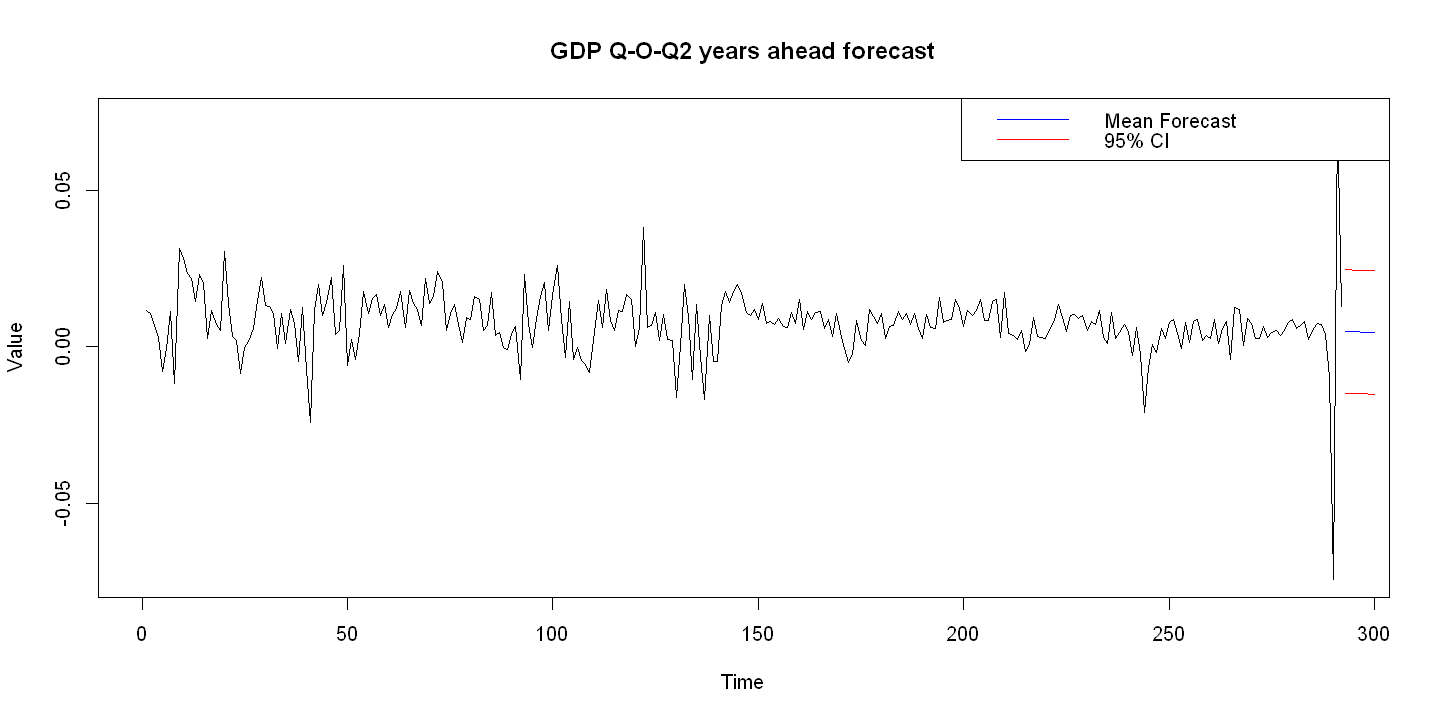

In [389]:
# HP filter specifications
print('Transforming data...')

## Differences of q-o-q and y-o-y
ham_qoq_change <- na.omit(diff(ham_trend, lag=1))
ham_yoy_change <- na.omit(diff(ham_trend, lag=4))

print('Data transformation to percentage changes complete.')

# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(ham_qoq_change, "Q-O-Q GDP")
runStructuralChecks(ham_yoy_change, "Y-O-Y GDP")

# Forecast using the GDP trend

par(mfrow=c(1,1))
ham_forecast <- forecastData(ham_qoq_change, periods=8, date_frequency="quarter", series_name="GDP Q-O-Q")

Here the spectra of differences tells a different story. It appears that some frequencies were *differenced away*, and the number of the highest frequencies dropped slightly. 
We do not have a rigorous tool in hand to argue fo this, but we can say with certainty that the impact is larger in this case.

The series remains strongly stationary throughout, which can be seen on the forecast graph, where the 2-year-ahead prediction is unswayed by the spike in volatility during the 2020 crisis.

##